## Optimizing Safe Control Policy over Trajectories

In [1]:
import numpy as np
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)

import os
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import itertools

from utils import load_data
import hardnet_aff
import baseline_dc3
import baseline_nn
import baseline_cbfqp
from test_nets import load_net_hardnetaff, load_net_dc3, load_net_nn, load_net_cbfqp

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

matplotlib.rcParams['text.usetex'] = True
plt.style.use('seaborn-whitegrid')

def simulate_policies(data, init_state, cost_fn, policy_list, label_list, color_list, linestyle_list, nstep=None, dt=None):
    """
    Plot the trajectories given policies.
    """
    fig = plt.figure(figsize=(4, 4))

    ## plot obstacles
    for obs in data.obs_list:
        ellipse = Ellipse((obs.cx, obs.cy), width=2*obs.rx, height=2*obs.ry, angle=0, color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
        plt.gca().add_artist(ellipse)

    for policy, label, c, ls in zip(policy_list, label_list, color_list, linestyle_list):
        policy.eval()
        if label == "CBF-QP":
            obs_list_original = data._obs_list
            data._obs_list = data._obs_list[:1]
        cost, traj = data.run_episode(policy, init_state, cost_fn, nstep=nstep, dt=dt, isTest=True, saveTraj=True)
        center_traj = data.sys.get_center(traj[:,0,:]).detach().cpu().numpy()
        plt.plot(center_traj[:,0], center_traj[:,1], ls, color=c, label=label+' (%.2f)'%cost[0], markersize=2, alpha=0.5)
        if label == "CBF-QP":
            data._obs_list = obs_list_original
    
    # plot start and goal point
    plt.scatter(center_traj[0,0], center_traj[0,1], s=100, color="k", facecolor="none", alpha=0.75, label="init. position")
    # plt.scatter(0.0, 0.0, s=100, color="purple", alpha=0.75, label="target position")

    # plt.title('Simulation Result')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend(ncol=1)
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-4,.5])
    # plt.ylim([-2.5,1.])
    plt.ylim([-1.5,1.])

    # 
    ax = plt.gca()
    handles, _labels = ax.get_legend_handles_labels()
    flip = lambda items: itertools.chain(*[items[i::2] for i in range(2)])
    ax.legend(flip(handles), flip(_labels), ncol=2, frameon=True)

    plt.show()

    return fig

tableau10 = [(31, 119, 180), (255, 127, 14),
                (44, 160, 44), (214, 39, 40),
                (227, 119, 194), (23, 190, 207), 
                (127, 127, 127), (140, 86, 75),
                (188, 189, 34), (148, 103, 189)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau10)):
    r, g, b = tableau10[i]
    tableau10[i] = (r / 255., g / 255., b / 255.)

folder_save = 'results/figures'

/tmp/ipykernel_4117965/3701271458.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
from datasets.cbf.safe_control import Obstacle

policy_list = []
label_list = []
prob_type = 'cbf'
net_str = 'seed1/net.dict' # ex) net_epoch0.dict, net.dict

sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
data = load_data(args, DEVICE)

class Nominal(nn.Module):
    def __init__(self, data):
        super().__init__()
        self._data = data

    def forward(self, x, isTest=False):
        # Return zero residual control
        return self._data.get_nominal_control(x) * 0
policy_nominal = Nominal(data)
policy_list.append(policy_nominal)
label_list.append('Nominal')

# CBF-QP
sys.argv = ['baseline_cbfqp.py', '--probType', prob_type]
args = baseline_nn.get_args('baselineCBFQP')
path = 'results/SafeControl-1000/baselineCBFQP/' + net_str
policy_list.append(load_net_cbfqp(data, args, path))
label_list.append('CBF-QP')

# NN
sys.argv = ['baseline_nn.py', '--probType', prob_type, '--softWeight', '0.0']
args = baseline_nn.get_args('baselineNN')
path = 'results/SafeControl-1000/baselineNN_noSoft/' + net_str
policy_list.append(load_net_nn(data, args, path))
label_list.append('NN')

# Soft
sys.argv = ['baseline_nn.py', '--probType', prob_type]
args = baseline_nn.get_args('baselineNN')
path = 'results/SafeControl-1000/baselineNN/' + net_str
policy_list.append(load_net_nn(data, args, path))
label_list.append('Soft')


# DC3
sys.argv = ['baseline_dc3.py', '--probType', prob_type]
args = baseline_dc3.get_args('baselineDC3')
path = 'results/SafeControl-1000/baselineDC3/' + net_str
policy_list.append(load_net_dc3(data, args, path))
label_list.append('DC3')


# hardnet
sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
path = 'results/SafeControl-1000/hardnetAff/' + net_str
policy_list.append(load_net_hardnetaff(data, args, path))
label_list.append('HardNet-Aff')


linestyle_list = [':o' if 'HardNet' in label else '-*' for label in label_list]

hardnetAff: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 0.01, 'softEpochs': 0}
baselineCBFQP: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nEx': 1000, 'epochs': None, 'batchSize': 100, 'lr': None, 'hiddenSize': None, 'saveAllStats': None, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 0.01, 'testProj': 'none'}
baselineNN: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 0.0, 'testProj': 'none'}
baselineNN: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 0.01, 'testProj': 'none'}
baselineDC3: {'probType': 'cbf', 'suffix':

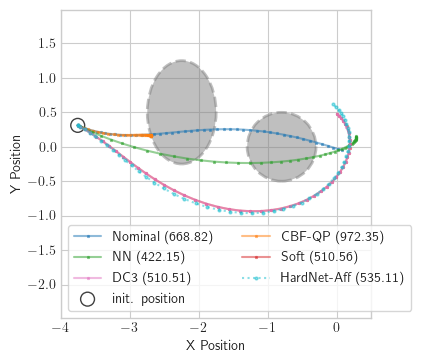

In [3]:
dt, nstep = 0.02, 50
np.random.seed(123)
init_state = torch.tensor(data._sys.generate_states(1), device=DEVICE)

cost_fn = data.evaluate
fig = simulate_policies(data, init_state, cost_fn, policy_list, label_list, tableau10, linestyle_list, nstep, dt)
# policy.set_projection(False)
fig.savefig(folder_save+'/cbf.pdf',dpi=300, bbox_inches='tight')

### Table

In [6]:
import numpy as np
import os
from utils import get_results, get_table_from_dict, get_latex_from_table

exp_dir = os.path.join('results', 'SafeControl-1000')
exp_status_dict, stats_dict = get_results(exp_dir, total_epoch=1000)

metrics = ['test_eval', 'train_loss', 'test_err1_max', 'test_err1_mean', 'test_err1_nviol', 'test_time', 'train_time']
metrics_renaming = ['Obj. value', 'Train loss', 'Max viol.', 'Mean viol.', 'Num viol.', 'Test Time (ms)', 'Train Time (min)']
# metrics = ['test_eval', 'test_err1_max', 'test_err1_mean', 'test_err1_nviol',
#             'test_ineq_max', 'test_ineq_mean', 'test_ineq_nviol', 'test_time', 'train_time']
# metrics_renaming = ['Obj. value', 'Max eq viol.', 'Mean eq viol.', 'Num eq viol.',
#                     'Max ineq viol.', 'Mean ineq viol.', 'Num ineq viol.', 'Test Time (ms)', 'Train Time (min)']
baselines = ['baselineCBFQP','baselineNN_noSoft', 'baselineNN', 'baselineDC3']
ours = ['hardnetAff']
methods_renaming_dict = dict((
        ('baselineCBFQP', 'CBF-QP'),
        ('baselineDC3', 'DC3'),
        ('baselineNN_noSoft', 'NN'),
        ('baselineNN', 'Soft'),
        ('hardnetAff', 'HardNet-Aff')
    ))

df, missing_methods = get_table_from_dict(stats_dict, metrics, baselines + ours, test_time_unit='ms', train_time_unit='min')
df.index = [methods_renaming_dict[x] if x in methods_renaming_dict else x for x in df.index]
df.columns = metrics_renaming

df

Reading baselineNN...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading hardnetAff...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading baselineNN_noSoft...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading baselineDC3...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading baselineCBFQP...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...


,Obj. value,Train loss,Max viol.,Mean viol.,Num viol.,Test Time (ms),Train Time (min)
CBF-QP,948.32 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),579.29 (4.60),0.00 (0.00)
NN,421.92 (0.15),412.84 (0.16),157.62 (0.90),118.92 (0.55),2.00 (0.00),0.23 (0.01),256.34 (4.01)
Soft,480.10 (0.54),479.98 (0.74),6.92 (0.05),3.95 (0.10),1.96 (0.06),0.22 (0.00),255.07 (0.77)
DC3,480.21 (0.71),479.99 (0.79),6.86 (0.13),3.88 (0.12),1.92 (0.10),15.71 (0.29),637.69 (6.71)
HardNet-Aff,518.85 (8.71),513.08 (6.85),0.00 (0.00),0.00 (0.00),0.00 (0.00),2.71 (0.06),370.05 (3.42)


### Dataset visualization

In [ ]:
X = data.sys.get_center(data.trainX).detach().cpu().numpy()

plt.figure(figsize=(4, 4))
plt.scatter(X[:,0], X[:,1], s=1)
for obs in data.obs_list:
    ellipse = Ellipse((obs.cx, obs.cy), width=2*obs.rx, height=2*obs.ry, angle=0, color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
    plt.gca().add_artist(ellipse)